In [2]:
import sys
from pathlib import Path
parent_dir = Path.cwd().parent
sys.path.append(str(parent_dir))

from PIL import Image
import sys
from pathlib import Path
from PIL import Image
import torch
import numpy as np
from molmo_utils import load_model, do_inference, get_coordinates, calculate_probability_of_coordinates
from utils import extract_all, plot_scatter, calculate_normalized_euclidian_distance, visualize_points_on_image, calculate_spread, calculate_all_clusters, show_all_clusters

2025-03-10 20:22:13.013525: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-10 20:22:13.055516: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-10 20:22:13.055554: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-10 20:22:13.055581: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-10 20:22:13.064692: I tensorflow/core/platform/cpu_feature_g

In [3]:
model_name = 'allenai/Molmo-7B-D-0924'
model, processor = load_model(model_name)

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

In [4]:
import string
import torch
import matplotlib.pyplot as plt

def create_vqa_prompt(coordinates, task, object, width, height):
    choices = list(string.ascii_lowercase)
    choices_string = ", ".join(choices[:len(coordinates)])
    prompt_coordinates = ""
    for i in range(len(coordinates)):
        prompt_coordinates += f"{choices[i]}: {coordinates[i]}, "
    prompt_coordinates = prompt_coordinates[:-2]

    prompt_start = "You are shown a robotic setting. Your mission is to point to the following object: "
    prompt_middle = f". You have to choose one out of {len(coordinates)} coordinates, to point to the object. The format of the possible answers looks like this: a: (x1, y1), b: (x2, y2), ... with (x1, y1) and (x2, y2) beeing the coordinates to choose from and a, b indicating the letter for each coordinate. The width of the image is {width} pixels and the height of the image is {height} pixels. The coordinates from which you have to choose are the following: " 
    prompt_end = f". Your output should be the letter of the best answer out of the choices: {choices_string}. Do not use whitespace before or after the letter. Do not output anything else."
    """
    prompt_start = "You are shown a robotic setting. Your mission is to point to the following object: "
    prompt_middle = f". Choose one of the following {len(coordinates)} coordinates that points to the object best: "
    
    prompt_end = f". For a coordinate (x,y) x indicates the pixel value on the x-axis and the y the pixel value on the y-axis. Your output should be the letter of the best answer out of the choices: {choices_string}. Do not use whitespace before or after the letter. Do not output anything else."
    """
    return prompt_start + object + prompt_middle + prompt_coordinates + prompt_end

def get_top_probability_distribution(output_char, output, tokenizer, top_k=10):
    softmax_fn = torch.nn.Softmax(dim=-1)

    logits = output.logits
    generated_logits = torch.cat(logits, dim=0)
    generated_tokens = output.sequences[0, inputs['input_ids'].size(1):]
    
    answer_token = generated_tokens[0]
    answer_logits = generated_logits[0]
    
    probs = softmax_fn(answer_logits.squeeze(0))
    
    token_prob = probs[answer_token].item()
    
    top_probs, top_indices = torch.topk(probs, top_k)
    top_tokens = [(tokenizer.decode([idx]), top_probs[i].item()) for i, idx in enumerate(top_indices)]

    return token_prob, top_tokens

def do_vqa(coordinates, task, object, image_path, model, processor, temperature):
    with Image.open(image_path) as image:
        width = image.width
        height = image.height
        prompt = create_vqa_prompt(coordinates, task, object, width, height)
        #print(f"Prompt: {prompt}")
        output_text, output, inputs = do_inference(image, prompt, model, processor, temperature)
    return output_text, output, inputs

def visualize_vqa(image, tokens, probs, coordinates, title="VQA"):
    sorted_coordinates = sort_coordinates_by_letters(tokens, coordinates)

    plt.imshow(image, alpha=1)
    image_width, image_height = image.size

    for prob, token, coordinate in zip(probs, tokens, sorted_coordinates):
        # Extract and plot the points
        x_coords = [x for x, y in [coordinate]]
        y_coords = [y for x, y in [coordinate]]
        label = f"{prob:.4f} ({token})"
        plt.scatter(x_coords, y_coords, marker='o', label=label)
    
    # Add labels and show the plot
    plt.title(title)
    plt.legend(loc="lower right")
    plt.axis("on")  # Show axes
    plt.show()
    plt.close()

def sort_coordinates_by_letters(letters, coordinates):
    """
    Sorts the list of coordinates based on the order of the permuted letter list.
    
    :param letters: List of unique lowercase letters (permutation of 'a' to some letter).
    :param coordinates: List of coordinates corresponding to the letters.
    :return: Sorted list of coordinates based on the sorted order of letters.
    """
    letters = [letter.strip() for letter in letters]
    
    expected_letters = [chr(i) for i in range(ord('a'), ord('a') + len(coordinates))]
    if sorted(letters) != expected_letters:
        raise ValueError(f"The letters list must contain a contiguous sequence from 'a' to '{expected_letters[-1]}'")
        
    letter_to_index = {letter: i for i, letter in enumerate(expected_letters)}
    sorted_coordinates = [coordinates[letter_to_index[letter]] for letter in letters]
    return sorted_coordinates

Task: pick up fruit and put it on the table.
 b: 0.4686
 a: 0.2887
 c: 0.2356
 d: 0.0010
 B: 0.0005
 The: 0.0004
 letter: 0.0003
b: 0.0003
 A: 0.0002
 C: 0.0002


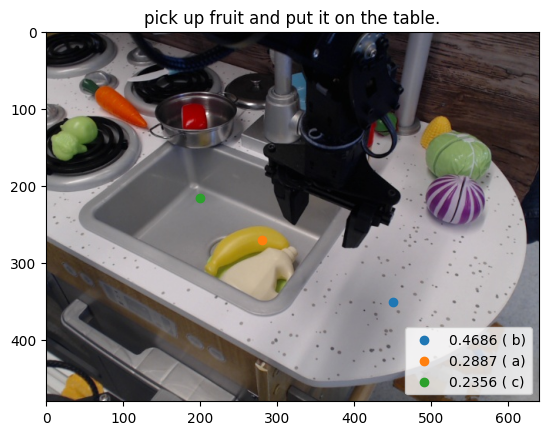

Task: pick up glass cup
 c: 0.3240
 b: 0.2775
 d: 0.2041
 a: 0.1888
 D: 0.0004
 letter: 0.0003
 C: 0.0003
 B: 0.0002
 The: 0.0002
b: 0.0001


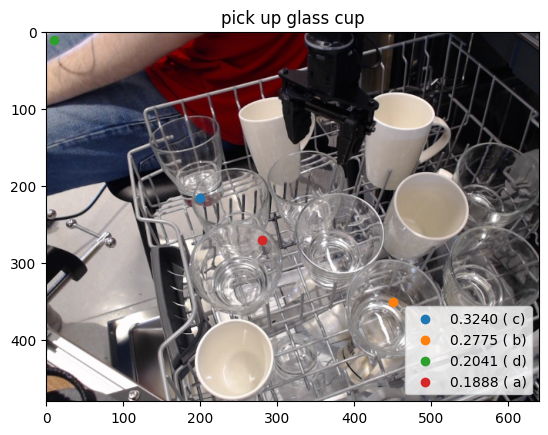

Task: Move the can from the top left of the burner to the bottom left of the burner
 a: 0.3258
 c: 0.3054
 d: 0.2116
 b: 0.1530
 D: 0.0003
 The: 0.0003
 C: 0.0002
 letter: 0.0002
 B: 0.0001
 f: 0.0001


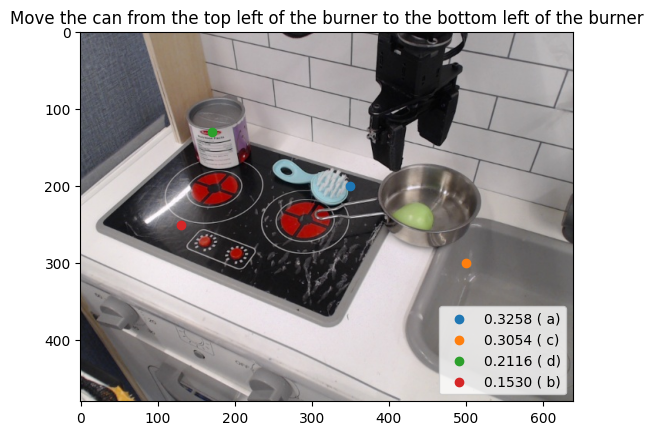

Task: pick up the can and put it next to the tomato
 c: 0.3835
 a: 0.2435
 d: 0.1889
 b: 0.1789
 D: 0.0004
 C: 0.0004
 The: 0.0003
 B: 0.0002
 letter: 0.0001
 A: 0.0001


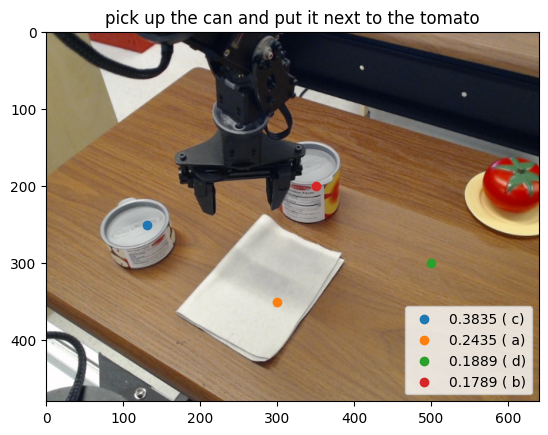

In [5]:
#task8 - can - (130,250) (380, 200) / (500, 300) (300, 350)
#task2 - vegetable (280, 270) (110, 90) (550, 200) / (205, 100) (450, 350) (200, 215)

tasks, images, groundtruths, objects_list = extract_all("../data/uncertain_experiments")
for i in range(len(tasks)):
    task = tasks[i]
    object = objects_list[i][0]
    image_path = images[i]
    
    if("task10" in image_path):
        coordinates = [(280, 270), (450, 350), (200, 215), (10, 10)]
    elif("task2" in image_path):
        coordinates = [(280, 270), (450, 350), (200, 215)]
    elif("task8" in image_path):
        coordinates = [(300, 350), (350, 200), (130, 250), (500, 300)]
    elif("bridge_2_can" in image_path):
        coordinates = [(350, 200), (130, 250), (500, 300), (170, 130)]
    else:
        #coordinates = [(300, 350), (350, 200), (130, 250), (500, 300)]
        continue

    print(f"Task: {task}")
    
    output_text, output, inputs = do_vqa(coordinates, task, object, image_path, model, processor, 0.2)
    
    token_prob, top_tokens= get_top_probability_distribution(output_text, output, processor.tokenizer)
    for token, prob in top_tokens:
        print(f"{token}: {prob:.4f}")
    
    with Image.open(image_path) as image:  
        tokens, probs = zip(*top_tokens[:len(coordinates)])
        visualize_vqa(image, tokens, probs, coordinates, title=task)


[(450, 350), (200, 215), (280, 270), (540, 180)]
[(' c', 0.4075748920440674), (' d', 0.2501206696033478), (' a', 0.17156982421875), (' b', 0.16499710083007812)]
[(450, 350), (540, 180), (280, 270), (200, 215)]
[(' c', 0.4133244752883911), (' d', 0.222102552652359), (' a', 0.18978893756866455), (' b', 0.16896671056747437)]
[(450, 350), (200, 215), (540, 180), (280, 270)]
[(' c', 0.3400777578353882), (' d', 0.30663517117500305), (' a', 0.19564813375473022), (' b', 0.15194372832775116)]
[(450, 350), (280, 270), (540, 180), (200, 215)]
[(' c', 0.3640904128551483), (' d', 0.22906900942325592), (' a', 0.2151641547679901), (' b', 0.18559634685516357)]
[(540, 180), (450, 350), (280, 270), (200, 215)]
[(' c', 0.39579981565475464), (' b', 0.2182614803314209), (' d', 0.20938816666603088), (' a', 0.17089764773845673)]
[(280, 270), (450, 350), (540, 180), (200, 215)]
[(' c', 0.4127160906791687), (' b', 0.22943085432052612), (' d', 0.2013382762670517), (' a', 0.15094274282455444)]
[(200, 215), (280,

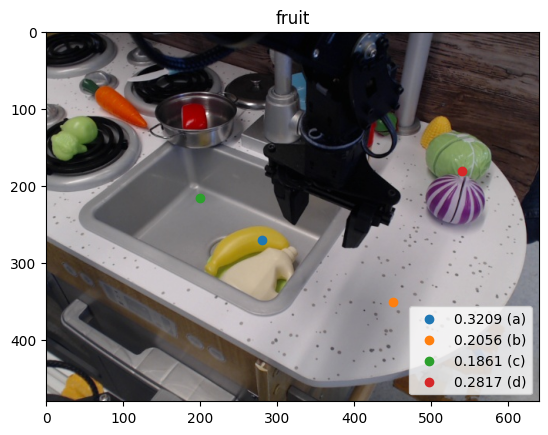

[(10, 10), (200, 215), (450, 350), (280, 270)]
[(' c', 0.5381438136100769), (' d', 0.22477027773857117), (' b', 0.1889062523841858), (' a', 0.04315025359392166)]
[(450, 350), (200, 215), (280, 270), (10, 10)]
[(' c', 0.3806397020816803), (' a', 0.25517532229423523), (' d', 0.19824616611003876), (' b', 0.16023138165473938)]
[(200, 215), (450, 350), (10, 10), (280, 270)]
[(' b', 0.32584092020988464), (' d', 0.29343992471694946), (' c', 0.22318284213542938), (' a', 0.15249502658843994)]
[(450, 350), (280, 270), (10, 10), (200, 215)]
[(' a', 0.3010912537574768), (' c', 0.26831963658332825), (' d', 0.23471921682357788), (' b', 0.1900814026594162)]
[(10, 10), (450, 350), (200, 215), (280, 270)]
[(' b', 0.4135597050189972), (' c', 0.3156968355178833), (' d', 0.20603057742118835), (' a', 0.059724561870098114)]
[(280, 270), (200, 215), (10, 10), (450, 350)]
[(' c', 0.3035212457180023), (' d', 0.28541043400764465), (' a', 0.2271050214767456), (' b', 0.17860527336597443)]
[(450, 350), (10, 10), (

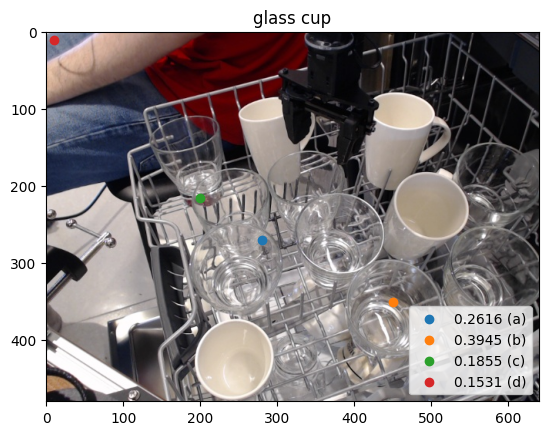

[(120, 200), (250, 250), (200, 400), (170, 100)]
[(' c', 0.5511433482170105), (' d', 0.20216116309165955), (' b', 0.15637066960334778), (' a', 0.08518347144126892)]
[(120, 200), (250, 250), (170, 100), (200, 400)]
[(' c', 0.4405551552772522), (' d', 0.2265017032623291), (' a', 0.1690218299627304), (' b', 0.15893645584583282)]
[(200, 400), (120, 200), (170, 100), (250, 250)]
[(' c', 0.3747337758541107), (' d', 0.2342734932899475), (' a', 0.20215369760990143), (' b', 0.18294304609298706)]
[(250, 250), (170, 100), (120, 200), (200, 400)]
[(' c', 0.35036367177963257), (' d', 0.2696845233440399), (' b', 0.19464999437332153), (' a', 0.18008776009082794)]
[(250, 250), (120, 200), (170, 100), (200, 400)]
[(' c', 0.3737477958202362), (' d', 0.28211963176727295), (' a', 0.1736392229795456), (' b', 0.16552597284317017)]
[(170, 100), (200, 400), (250, 250), (120, 200)]
[(' c', 0.47744134068489075), (' b', 0.25701066851615906), (' d', 0.15379628539085388), (' a', 0.10611623525619507)]
[(170, 100), 

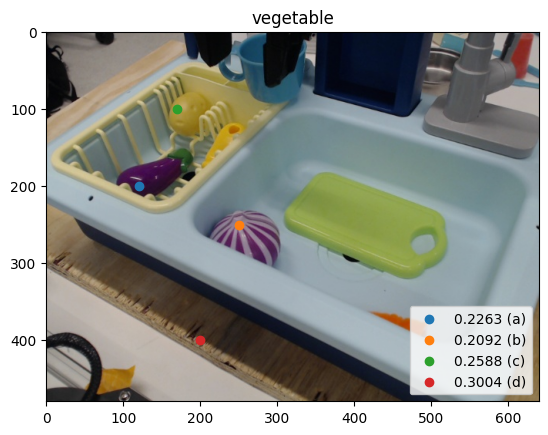

[(100, 300), (400, 400), (250, 250), (200, 400), (300, 150)]
[(' d', 0.4178561270236969), (' c', 0.34913188219070435), (' b', 0.10081248730421066), (' e', 0.08006136864423752), (' a', 0.04651731997728348)]
[(100, 300), (400, 400), (250, 250), (300, 150), (200, 400)]
[(' d', 0.46654221415519714), (' c', 0.32316434383392334), (' b', 0.1006016656756401), (' e', 0.060013361275196075), (' a', 0.04459814354777336)]
[(250, 250), (200, 400), (400, 400), (100, 300), (300, 150)]
[(' d', 0.3783194124698639), (' c', 0.29578861594200134), (' b', 0.12918893992900848), (' a', 0.0990767702460289), (' e', 0.09216951578855515)]
[(400, 400), (250, 250), (200, 400), (100, 300), (300, 150)]
[(' d', 0.42447981238365173), (' c', 0.27299630641937256), (' e', 0.11505893617868423), (' b', 0.10106923431158066), (' a', 0.07975739240646362)]
[(400, 400), (300, 150), (100, 300), (250, 250), (200, 400)]
[(' d', 0.505856454372406), (' c', 0.1927529275417328), (' b', 0.15503263473510742), (' a', 0.07926028966903687), 

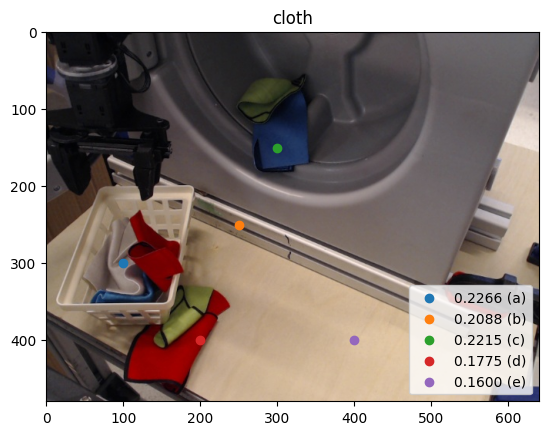

[(350, 200), (170, 130), (500, 300), (130, 250)]
[(' a', 0.3301791846752167), (' c', 0.322530597448349), (' b', 0.18923600018024445), (' d', 0.15384778380393982)]
[(170, 130), (130, 250), (350, 200), (500, 300)]
[(' c', 0.43957069516181946), (' a', 0.24863210320472717), (' b', 0.206930011510849), (' d', 0.10045645385980606)]
[(170, 130), (350, 200), (500, 300), (130, 250)]
[(' c', 0.3453975021839142), (' a', 0.28634458780288696), (' b', 0.18560154736042023), (' d', 0.1784912496805191)]
[(130, 250), (170, 130), (500, 300), (350, 200)]
[(' c', 0.37363412976264954), (' b', 0.22066941857337952), (' a', 0.21895214915275574), (' d', 0.18222816288471222)]
[(500, 300), (170, 130), (130, 250), (350, 200)]
[(' c', 0.39374545216560364), (' b', 0.36916789412498474), (' d', 0.1338343769311905), (' a', 0.0994572639465332)]
[(350, 200), (170, 130), (500, 300), (130, 250)]
[(' a', 0.3301791846752167), (' c', 0.322530597448349), (' b', 0.18923600018024445), (' d', 0.15384778380393982)]
[(170, 130), (13

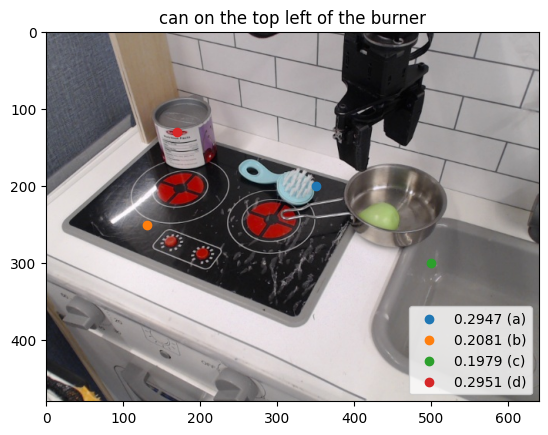

[(270, 400), (200, 215), (350, 400)]
[(' b', 0.34284791350364685), (' a', 0.32714778184890747), (' c', 0.320820152759552)]
[(270, 400), (200, 215), (350, 400)]
[(' b', 0.34284791350364685), (' a', 0.32714778184890747), (' c', 0.320820152759552)]
[(350, 400), (200, 215), (270, 400)]
[(' c', 0.39341312646865845), (' b', 0.2992929220199585), (' a', 0.29812610149383545)]
[(270, 400), (350, 400), (200, 215)]
[(' b', 0.40294149518013), (' c', 0.319376140832901), (' a', 0.2678931951522827)]
[(200, 215), (270, 400), (350, 400)]
[(' b', 0.43073830008506775), (' c', 0.32009753584861755), (' a', 0.2406802922487259)]
[(270, 400), (200, 215), (350, 400)]
[(' b', 0.34284791350364685), (' a', 0.32714778184890747), (' c', 0.320820152759552)]
[(270, 400), (350, 400), (200, 215)]
[(' b', 0.40294149518013), (' c', 0.319376140832901), (' a', 0.2678931951522827)]
[(350, 400), (270, 400), (200, 215)]
[(' b', 0.3845781981945038), (' c', 0.3684033453464508), (' a', 0.2378590703010559)]
[(270, 400), (200, 215)

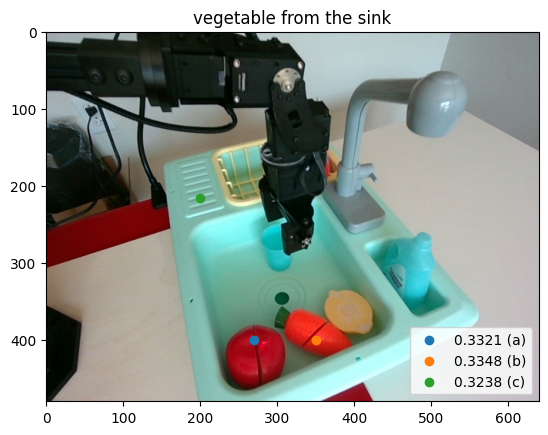

[(500, 300), (130, 250), (300, 350), (350, 200)]
[(' c', 0.39049068093299866), (' a', 0.2293335646390915), (' d', 0.1908683180809021), (' b', 0.1839151382446289)]
[(300, 350), (130, 250), (500, 300), (350, 200)]
[(' c', 0.43634068965911865), (' d', 0.19400355219841003), (' a', 0.19249379634857178), (' b', 0.1718776375055313)]
[(350, 200), (300, 350), (500, 300), (130, 250)]
[(' c', 0.5281857848167419), (' d', 0.1846878081560135), (' b', 0.1748589128255844), (' a', 0.10772743821144104)]
[(350, 200), (500, 300), (300, 350), (130, 250)]
[(' c', 0.4269865155220032), (' d', 0.22721417248249054), (' b', 0.2001245617866516), (' a', 0.14053046703338623)]
[(130, 250), (350, 200), (500, 300), (300, 350)]
[(' c', 0.46090826392173767), (' b', 0.21686884760856628), (' d', 0.1669299155473709), (' a', 0.15022066235542297)]
[(500, 300), (130, 250), (300, 350), (350, 200)]
[(' c', 0.39049068093299866), (' a', 0.2293335646390915), (' d', 0.1908683180809021), (' b', 0.1839151382446289)]
[(350, 200), (500

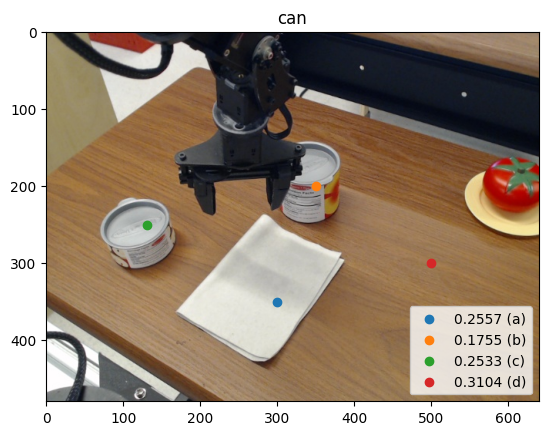

In [6]:
import random
RUNS = 10
tasks, images, groundtruths, objects_list = extract_all("../data/uncertain_experiments")
for i in range(len(tasks)):
    task = tasks[i]
    image_path = images[i]
    object = objects_list[i][0]
    if("task10" in image_path):
        coordinates = [(280, 270), (450, 350), (200, 215), (10, 10)]
    elif("task1" in image_path):
        coordinates = [(100, 300), (250, 250), (300, 150), (200, 400), (400, 400)]    
    elif("task2" in image_path):
        coordinates = [(280, 270), (450, 350), (200, 215), (540,180)]
    elif("task3" in image_path):
        coordinates = [(120, 200), (250, 250), (170, 100),(200, 400)]  
    elif("task4" in image_path):
        coordinates = [(270, 400), (350, 400), (200, 215)]
    elif("task8" in image_path):
        coordinates = [(300, 350), (350, 200), (130, 250), (500, 300)]
    elif("bridge_2_can" in image_path):
        coordinates = [(350, 200), (130, 250), (500, 300), (170, 130)]
    else:
        #coordinates = [(300, 350), (350, 200), (130, 250), (500, 300)]
        continue
    summed_probs = {coord: 0 for coord in coordinates}
    for i in range(RUNS):
        shuffled = random.sample(coordinates, len(coordinates))
        
        output_text, output, inputs = do_vqa(shuffled, task, object, image_path, model, processor, 0.2)
        
        token_prob, top_tokens= get_top_probability_distribution(output_text, output, processor.tokenizer, len(coordinates))
        print(shuffled)
        print(top_tokens)
        for token, prob in top_tokens:
            #print(f"{token}: {prob:.4f}")
            summed_probs[shuffled[ord(token.strip()) - ord('a')]] += prob
            
    average_probs = [ prob / RUNS for coord, prob in summed_probs.items() ]
    with Image.open(image_path) as image:
        visualize_vqa(image, list(string.ascii_lowercase[:len(coordinates)]), average_probs, coordinates, title=object)